# Problem Set 3 -Yutao Chen

In [1]:
## Library Packages loading
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import itertools
import seaborn as sns
import math
import sympy as sy
import warnings
warnings.filterwarnings("ignore")

## Matching the U.S. income distribution by GMM

In [2]:
# data loading
income_df = pd.read_csv("data/hh_inc_synth.txt", header=None)
income_df.describe()

,0
count,121085.000000
mean,67269.598229
std,60632.541408
min,1.083078
25%,24954.988251
50%,50090.025355
75%,89990.466103
max,349978.769501


### 1.(a) 
Use the numpy.histogram() function to create the moments in Table 1 from the synthetic household income data in comma-delimited text file hh inc synth.txt by inputing the appropriate list of bin edges for the bins argument.

In [3]:
bin_edges = list(np.linspace(0,200000,41)) + [250000,350000]
income_hist = np.histogram(income_df[0], bins=bin_edges, weights=[1/len(income_df)]*len(income_df))
income_hist

(array([0.03519016, 0.04106206, 0.05885948, 0.05683611, 0.0585952 ,
        0.05443284, 0.05506049, 0.05067515, 0.04785894, 0.04083908,
        0.04269728, 0.03509931, 0.03660239, 0.03168022, 0.02978073,
        0.0285089 , 0.0250733 , 0.02119172, 0.02142297, 0.01859025,
        0.02086964, 0.01462609, 0.01422967, 0.01295784, 0.01271834,
        0.0103894 , 0.01000124, 0.00758145, 0.00851468, 0.00737498,
        0.0096296 , 0.00611141, 0.00575629, 0.00503778, 0.00509559,
        0.00437709, 0.00379898, 0.00299789, 0.00313829, 0.0025767 ,
        0.01897014, 0.02319032]),
 array([     0.,   5000.,  10000.,  15000.,  20000.,  25000.,  30000.,
         35000.,  40000.,  45000.,  50000.,  55000.,  60000.,  65000.,
         70000.,  75000.,  80000.,  85000.,  90000.,  95000., 100000.,
        105000., 110000., 115000., 120000., 125000., 130000., 135000.,
        140000., 145000., 150000., 155000., 160000., 165000., 170000.,
        175000., 180000., 185000., 190000., 195000., 200000., 25000

### 1.(b)
Plot the histogram of the data hh inc synth.txt using the bins described in the first column of Table 1, which you used as an input to part (a), and the height being the percent of observations in that bin and not the count frequency (use the weights option rather than the density option in matplotlib.pyplot.hist).

In [4]:
# weight adjustment
adjust_weights = []
for i in income_df[0]:
    if i<200000:
        adjust_weights.append(1/len(income_df[0]))
    elif i<250000:
        adjust_weights.append(1/(len(income_df[0])*10))
    else:
        adjust_weights.append(1/(len(income_df[0])*20))
adjust_weights

[8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 8.258661271007969e-06,
 4.1293306355039

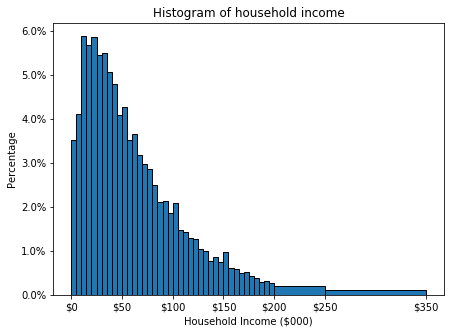

In [5]:
plt.rcParams['figure.figsize'] = (7,5)
ax = plt.subplot()
income_count, income_bins, income_ignored = ax.hist(income_df[0], bins=np.array(bin_edges), weights=adjust_weights, edgecolor='k')
ax.set_title('Histogram of household income')
ax.set_xlabel('Household Income ($000)')
ax.set_xticks(np.array([0, 50000, 100000, 150000, 200000, 250000, 350000]))
ax.xaxis.set_ticklabels(('$0', '$50', '$100', '$150', '$200', '$250', '$350'))
ax.set_ylabel('Percentage')
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0))
plt.show()

### 1.(c)
Using GMM, fit the lognormal $LN(x;\mu,\sigma)$ distribution defined in the MLE notebook to the distribution of household income data using the moments from the data file. Make sure to try various initial guesses.

In [6]:
# generate model moments
income_data_moments = income_hist[0]
def LN_get_model_moments(mu, sigma, bin_edges): 
    return (sp.stats.lognorm.cdf(bin_edges[1:], s=sigma, scale=np.exp(mu)))-(sp.stats.lognorm.cdf(bin_edges[:-1], s=sigma, scale=np.exp(mu)))

# define error function
def LN_err_vec(data_moments, mu, sigma, bin_edges, simple):
    model_moments = LN_get_model_moments(mu, sigma, bin_edges)
    if simple:
        return  model_moments - data_moments
    else:
        return (model_moments - data_moments) / model_moments
    
# define criterion function
def LN_criterion(paras, *args):
    mu, sigma = paras
    data_moments, bin_edges, simple, W = args
    error_vec = LN_err_vec(data_moments, mu, sigma, bin_edges, simple)
    return error_vec.T @ W @ error_vec

In [7]:
# perform GMM estimation for a single guess
W_fixed = np.diag(income_data_moments)
initial = np.array((np.log(income_df[0]).mean(), np.log(income_df[0]).std()))
LN_result = sp.optimize.minimize(LN_criterion, initial, args=(income_data_moments, np.array(bin_edges), False, W_fixed), method="SLSQP",
                                 tol = 1e-20, bounds=[(None, None), (1e-10, None)])
LN_result

     fun: 0.0599816953312616
     jac: array([5.91389835e-08, 3.91155481e-08])
 message: 'Optimization terminated successfully.'
    nfev: 73
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([10.78035699,  1.12767186])

In [8]:
# test another error function
initial = np.array((np.log(income_df[0]).mean(), np.log(income_df[0]).std()))
LN_result = sp.optimize.minimize(LN_criterion, initial, args=(income_data_moments, np.array(bin_edges), True, W_fixed), method="SLSQP",
                                 tol = 1e-20, bounds=[(None, None), (1e-10, None)])
LN_result

     fun: 3.5229202522108774e-05
     jac: array([6.82121026e-12, 6.36646291e-12])
 message: 'Optimization terminated successfully.'
    nfev: 74
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([10.86229888,  1.02299594])

In [9]:
# test the sensitivity of the initial values
mu_initials = sp.stats.uniform.rvs(-2*np.log(income_df[0]).mean(), 4*np.log(income_df[0]).mean(), 20)
sigma_initials = sp.stats.uniform.rvs(0, 10*np.log(income_df[0]).std(), 20)
LN_results = []
for i in zip(mu_initials, sigma_initials):
    temp_result = sp.optimize.minimize(LN_criterion, i, args=(income_data_moments, np.array(bin_edges), False, W_fixed), method="SLSQP",
                                       tol = 1e-50, bounds=[(None, None), (1e-10, None)])
    LN_results.append(temp_result)

LN_best = sorted(LN_results, key=lambda x:x.fun)[0]
LN_best

     fun: 0.05998169533126129
     jac: array([5.54136932e-08, 6.42612576e-08])
 message: 'Optimization terminated successfully.'
    nfev: 159
     nit: 32
    njev: 32
  status: 0
 success: True
       x: array([10.780357  ,  1.12767186])

In [10]:
print('estimated mu: {}'.format(LN_best.x[0]))
print('estimated sigma: {}'.format(LN_best.x[1]))

estimated mu: 10.780356998302093
estimated sigma: 1.1276718640046786


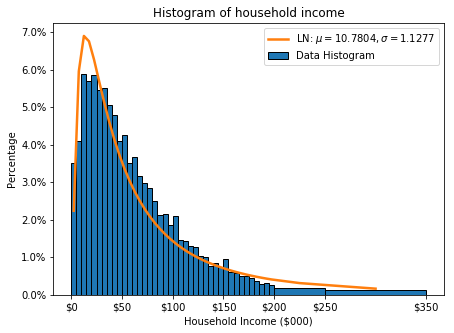

In [11]:
# plot the GMM estimated LN percentage histogram
plt.rcParams['figure.figsize'] = (7,5)
LN_ax = plt.subplot()
income_count, income_bins, income_ignored = LN_ax.hist(income_df[0], bins=np.array(bin_edges), edgecolor='k',
                                                       weights=adjust_weights, label = 'Data Histogram') 

LN_x = np.array([(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])
LN_y = LN_get_model_moments(LN_best.x[0], LN_best.x[1], np.array(bin_edges))
# adjustment
LN_y[-1] /= 20
LN_y[-2] /= 10
LN_ax.plot(LN_x, LN_y, linewidth=2.5, label=r'LN: $\mu={}, \sigma={}$'.format(round(LN_best.x[0],4),round(LN_best.x[1],4)))

LN_ax.set_title('Histogram of household income')
LN_ax.set_xlabel('Household Income ($000)')
LN_ax.set_xticks(np.array([0, 50000, 100000, 150000, 200000, 250000, 350000]))
LN_ax.xaxis.set_ticklabels(('$0', '$50', '$100', '$150', '$200', '$250', '$350'))
LN_ax.set_ylabel('Percentage')
LN_ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0))
LN_ax.legend()
plt.show()

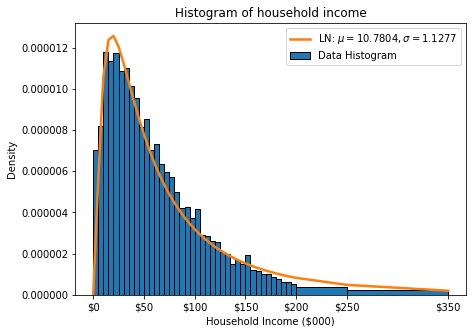

In [12]:
# plot the GMM estimated LN density histogram
plt.rcParams['figure.figsize'] = (7,5)
plt.hist(income_df[0], bins=np.array(bin_edges), edgecolor='k', density = True, label = 'Data Histogram') 
plt.plot(np.array(bin_edges), sp.stats.lognorm.pdf(np.array(bin_edges), s=LN_result.x[1], scale=np.exp(LN_result.x[0])),
         linewidth=2.5, label=r'LN: $\mu={}, \sigma={}$'.format(round(LN_best.x[0],4),round(LN_best.x[1],4)))
plt.title('Histogram of household income')
plt.xlabel('Household Income ($000)')
plt.xticks(np.array([0, 50000, 100000, 150000, 200000, 250000, 350000]), ('$0', '$50', '$100', '$150', '$200', '$250', '$350'))
plt.ylabel('Density')
plt.legend()
plt.show()

### 1.(d)
Using GMM, fit the gamma $GA(x; \alpha,\beta)$ distribution defined in the MLE notebook to the distribution of household income data using the moments from the data file. Use $\alpha_{0}=3$ and $\beta_{0}=20000$ as your initial guess.

In [13]:
# generate model moments
income_data_moments = income_hist[0]
def GA_get_model_moments(alpha, beta, bin_edges): 
    return (sp.stats.gamma.cdf(bin_edges[1:], a=alpha, loc=0, scale=beta))-(sp.stats.gamma.cdf(bin_edges[:-1], a=alpha, loc=0, scale=beta))

# define error function
def GA_err_vec(data_moments, alpha, beta, bin_edges, simple):
    model_moments = GA_get_model_moments(alpha, beta, bin_edges)
    if simple:
        return  model_moments - data_moments
    else:
        return (model_moments - data_moments) / model_moments
    
# define criterion function
def GA_criterion(paras, *args):
    alpha, beta, = paras
    data_moments, bin_edges, simple, W = args
    error_vec = GA_err_vec(data_moments, alpha, beta, bin_edges, simple)
    return error_vec.T @ W @ error_vec

In [14]:
# perform GMM estimation for a single guess
W_fixed = np.diag(income_data_moments)
#initial = np.array([(income_df[0].mean())**2/(income_df[0].std())**2, (income_df[0].std())**2/income_df[0].mean()])
initial = np.array((3,20000))
GA_result = sp.optimize.minimize(GA_criterion, initial, args=(income_data_moments, np.array(bin_edges), True, W_fixed), method="SLSQP",
                                 tol = 1e-20, bounds=[(1e-10, None), (1e-10, None)])
GA_result

     fun: 1.094699403323479e-05
     jac: array([ 7.16227078e-12, -1.93267624e-12])
 message: 'Optimization terminated successfully.'
    nfev: 226
     nit: 45
    njev: 45
  status: 0
 success: True
       x: array([1.39840634e+00, 4.64884058e+04])

In [15]:
# test another arror function
initial = np.array((3,20000))
GA_result = sp.optimize.minimize(GA_criterion, initial, args=(income_data_moments, np.array(bin_edges), False, W_fixed), method="SLSQP",
                                 tol = 1e-20, bounds=[(1e-10, None), (1e-10, None)])
GA_result

     fun: 0.019026004416377723
     jac: array([1.39931217e-07, 5.05242497e-08])
 message: 'Optimization terminated successfully.'
    nfev: 305
     nit: 57
    njev: 57
  status: 0
 success: True
       x: array([1.27140195e+00, 5.55123580e+04])

In [16]:
# test the sensitivity of the initial values
alpha_initials = sp.stats.uniform.rvs(1e-10, 10, 20)
beta_initials = sp.stats.uniform.rvs(1e-10, 30000, 20)
GA_results = []
for i in zip(alpha_initials, beta_initials):
    temp_result = sp.optimize.minimize(GA_criterion, i, args=(income_data_moments, np.array(bin_edges), False, W_fixed), method="SLSQP",
                                       tol = 1e-50, options={'maxiter':1000}, bounds=[(1e-10, None), (1e-10, None)])
    GA_results.append(temp_result)

GA_best = sorted(GA_results, key=lambda x:x.fun)[0]
GA_best

     fun: 0.019025987303750262
     jac: array([3.63215804e-08, 4.88944352e-08])
 message: 'Optimization terminated successfully.'
    nfev: 303
     nit: 59
    njev: 59
  status: 0
 success: True
       x: array([1.27115635e+00, 5.55254549e+04])

In [17]:
print('estimated alpha: {}'.format(GA_best.x[0]))
print('estimated beta: {}'.format(GA_best.x[1]))

estimated alpha: 1.2711563462776059
estimated beta: 55525.454858273


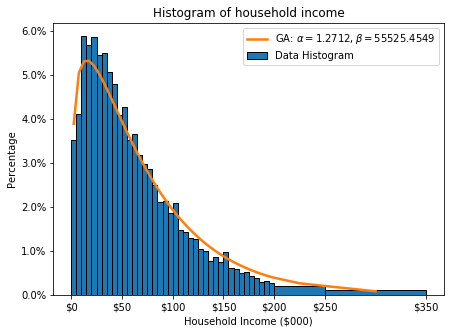

In [18]:
# plot the GMM estimated GA percentage histogram
plt.rcParams['figure.figsize'] = (7,5)
GA_ax = plt.subplot()
income_count, income_bins, income_ignored = GA_ax.hist(income_df[0], bins=np.array(bin_edges), edgecolor='k',
                                                       weights=adjust_weights, label = 'Data Histogram') 

GA_x = np.array([(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])
GA_y = GA_get_model_moments(GA_best.x[0], GA_best.x[1], np.array(bin_edges))
# adjustment
GA_y[-1] /= 20
GA_y[-2] /= 10
GA_ax.plot(GA_x, GA_y, linewidth=2.5, label=r'GA: $\alpha={}, \beta={}$'.format(round(GA_best.x[0],4),round(GA_best.x[1],4)))

GA_ax.set_title('Histogram of household income')
GA_ax.set_xlabel('Household Income ($000)')
GA_ax.set_xticks(np.array([0, 50000, 100000, 150000, 200000, 250000, 350000]))
GA_ax.xaxis.set_ticklabels(('$0', '$50', '$100', '$150', '$200', '$250', '$350'))
GA_ax.set_ylabel('Percentage')
GA_ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0))
GA_ax.legend()
plt.show()

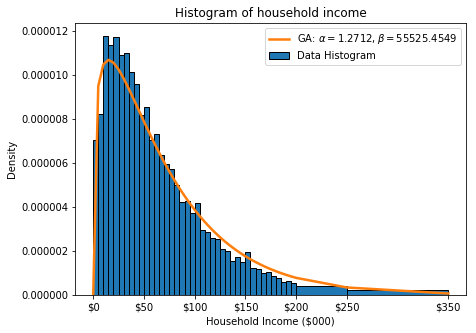

In [19]:
# plot the GMM estimated GA density histogram
plt.rcParams['figure.figsize'] = (7,5)
plt.hist(income_df[0], bins=np.array(bin_edges), edgecolor='k', density = True, label = 'Data Histogram') 
plt.plot(np.array(bin_edges), sp.stats.gamma.pdf(np.array(bin_edges), a=GA_best.x[0], loc=0, scale=GA_best.x[1]),
         linewidth=2.5, label=r'GA: $\alpha={}, \beta={}$'.format(round(GA_best.x[0],4),round(GA_best.x[1],4)))
plt.title('Histogram of household income')
plt.xlabel('Household Income ($000)')
plt.xticks(np.array([0, 50000, 100000, 150000, 200000, 250000, 350000]), ('$0', '$50', '$100', '$150', '$200', '$250', '$350'))
plt.ylabel('Density')
plt.legend()
plt.show()

### 1.(e)
Plot the histogram from part (a) overlayed with the line representing the implied histogram from your estimated lognormal (LN) distribution from part (b) and the line representing the implied histogram from your estimated gamma (GA) distribution from part (c). What is the most precise way to tell which distribution fits the data the best? Which estimated distribution—LN or GA—fits the data best?

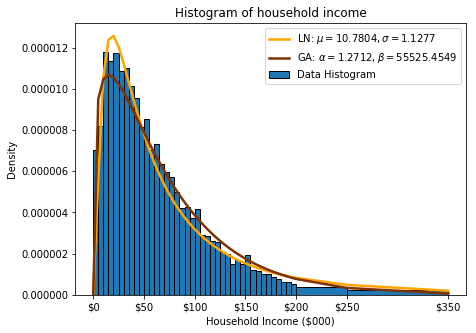

In [20]:
# plots the aggregated density histogram
plt.rcParams['figure.figsize'] = (7,5)
plt.hist(income_df[0], bins=np.array(bin_edges), edgecolor='k', density = True, label = 'Data Histogram') 
plt.plot(np.array(bin_edges), sp.stats.lognorm.pdf(np.array(bin_edges), s=LN_result.x[1], scale=np.exp(LN_result.x[0])),
         linewidth=2.5, color='orange', label=r'LN: $\mu={}, \sigma={}$'.format(round(LN_best.x[0],4),round(LN_best.x[1],4)))
plt.plot(np.array(bin_edges), sp.stats.gamma.pdf(np.array(bin_edges), a=GA_best.x[0], loc=0, scale=GA_best.x[1]),
         linewidth=2.5, color=(0.5,0.2,0), label=r'GA: $\alpha={}, \beta={}$'.format(round(GA_best.x[0],4),round(GA_best.x[1],4)))
plt.title('Histogram of household income')
plt.xlabel('Household Income ($000)')
plt.xticks(np.array([0, 50000, 100000, 150000, 200000, 250000, 350000]), ('$0', '$50', '$100', '$150', '$200', '$250', '$350'))
plt.ylabel('Density')
plt.legend()
plt.show()

In [21]:
print("LN best score:", LN_best.fun)
print("GA best score:", GA_best.fun)

LN best score: 0.05998169533126129
GA best score: 0.019025987303750262


I think an accurate and convenient indicator to judge which estimation fits better is the values of the criterion functions. From above comparison, we can see that the estimated gamma distribution fits the data better than the estimated lognormal distribution because its criterion function value is smaller. Notice that the premise for using this criterion function as the metric is that the two estimations use the same error measurements, weighting matrix and also, the same moments.

## 1.(f)
Repeat your estimation of the GA distribution from part (c), but use the two-step estimator for the optimal weighting matrix. Do your estimates for $\alpha$ and $\beta$ change much? How can you compare the goodness of fit of this estimated distribution versus the goodness of fit of the estimated distribution in part (c)?

In [22]:
# calculate the error matrix and optimal weighting matrix 
def GA_err_matrix(observations, alpha, beta, bin_edges, simple):
    model_moments = GA_get_model_moments(alpha, beta, bin_edges)
    err_matrix = np.zeros((len(model_moments), len(observations)))
    for i in range(1,len(bin_edges)):
        obs_in_bin = (observations < bin_edges[i]) & (observations >= bin_edges[i-1])
        err_matrix[i-1, :] = model_moments[i-1] - obs_in_bin if simple else (model_moments[i-1] - obs_in_bin)/ model_moments[i-1]
    return err_matrix

income_err_matrix = GA_err_matrix(income_df[0], GA_best.x[0], GA_best.x[1], bin_edges, False)
income_VCV = (1/len(income_df[0]))*(income_err_matrix @ income_err_matrix.T)
W_second = np.linalg.inv(income_VCV)
W_second

array([[128.1500528 , 166.22869428, 174.81378457, ...,  13.25846777,
         86.0612406 ,  52.56835934],
       [166.22869428, 215.75622889, 226.83422084, ...,  17.20385727,
        111.6709495 ,  68.21147704],
       [174.81378457, 226.83422084, 238.59705608, ...,  18.09240305,
        117.43845596,  71.73423219],
       ...,
       [ 13.25846777,  17.20385727,  18.09240305, ...,   1.37844733,
          8.90691083,   5.4405836 ],
       [ 86.0612406 , 111.6709495 , 117.43845596, ...,   8.90691083,
         57.85103312,  35.31501297],
       [ 52.56835934,  68.21147704,  71.73423219, ...,   5.4405836 ,
         35.31501297,  21.58222707]])

In [23]:
initial = (GA_best.x[0], GA_best.x[1])
GA_2step = sp.optimize.minimize(GA_criterion, initial, args=(income_data_moments, np.array(bin_edges), False, W_second), method="SLSQP",
                                 tol = 1e-20, bounds=[(1e-10, None), (1e-10, None)])
GA_2step

     fun: 0.36880607411023336
     jac: array([2.05636024e-06, 5.72949648e-06])
 message: 'Optimization terminated successfully.'
    nfev: 154
     nit: 26
    njev: 26
  status: 0
 success: True
       x: array([1.30663699e+00, 5.25510267e+04])

In [24]:
print('GA original estimation: alpha: {}, beta: {}'.format(GA_best.x[0],GA_best.x[1]))
print('GA two-step estimation: alpha: {}, beta: {}'.format(GA_2step.x[0],GA_2step.x[1]))

GA original estimation: alpha: 1.2711563462776059, beta: 55525.454858273
GA two-step estimation: alpha: 1.3066369932386344, beta: 52551.02668279336


In [25]:
print('GA original criterion score (identity matrix): {}'.format(GA_criterion((GA_best.x[0],GA_best.x[1]), income_data_moments, bin_edges, False, np.eye(42))))
print('GA two-step criterion score (identity matrix): {}'.format(GA_criterion((GA_2step.x[0],GA_2step.x[1]), income_data_moments, bin_edges, False, np.eye(42))))

GA original criterion score (identity matrix): 1.3532012437476435
GA two-step criterion score (identity matrix): 1.3201670961385046


In [26]:
print('GA original criterion score (optimal matrix): {}'.format(GA_criterion((GA_best.x[0],GA_best.x[1]), income_data_moments, bin_edges, False, W_second)))
print('GA two-step criterion score (optimal matrix): {}'.format(GA_criterion((GA_2step.x[0],GA_2step.x[1]), income_data_moments, bin_edges, False, W_second)))

GA original criterion score (optimal matrix): 1.0000000005034102
GA two-step criterion score (optimal matrix): 0.36880607411023336


From the comparison above, we see that the new estimated $\alpha$ and $\beta$ do not vary much from the original estimates. $\alpha$ is increased a bit and $\beta$ decreased. When computing the criterion scores with the identity matrix and the optimal matrix, we found that the new estimates have a lower score for both cases, so it is reasonable to believe that the new estimated parameters fit the data better. Also, the GMM Variance-Covariance Estimator of the Estimated Parameters can give us some insights into the performance of these two fits.

 

## Estimating the Brock and Mirman (1972) model by GMM

In [5]:
macro_df = pd.read_csv("data/MacroSeries.txt", header=None)
macro_df = macro_df.rename(columns={0:'ct',1:'kt',2:'wt',3:'rt'})
macro_df

,ct,kt,wt,rt
0,1.067109e+07,8.040697e+06,1.059438e+07,0.954120
1,1.169487e+07,7.595072e+06,1.161079e+07,1.107009
2,9.292394e+06,8.323735e+06,9.225588e+06,0.802596
3,7.913165e+06,6.613792e+06,7.856274e+06,0.860176
4,8.140994e+06,5.632136e+06,8.082466e+06,1.039183
5,8.274414e+06,5.794292e+06,8.214926e+06,1.026655
6,8.625916e+06,5.889252e+06,8.563901e+06,1.053011
7,9.012820e+06,6.139431e+06,8.948024e+06,1.055408
8,8.788320e+06,6.414808e+06,8.725138e+06,0.984940
9,9.720972e+06,6.255021e+06,9.651085e+06,1.117297


### 2.(a)
Estimate $\alpha$, $\rho$, and $\mu$ by GMM using the unconditional moment

In [130]:
import statsmodels.tsa.ar_model as ar
# calculate zt with equation(4)
def zt4(alpha, df):
    rt = np.array(df['rt'])
    kt = np.array(df['kt'])
    return np.array((np.log(rt)-np.log(alpha)-(alpha-1)*np.log(kt)))

# using AR(1) regression to reduce the number of parameters to guess, only need to guess alpha

def AR1(zt):
    AR = ar.AR(zt)
    AR1_result = AR.fit(maxlag=1,trend='c')
    rho = AR1_result.params[1]
    mu = AR1_result.params[0]/(1-rho)
    return rho,mu

# generate data moments
def expectation_data_moments(df, paras):
    alpha, rho, mu = paras
    beta = 0.99
    ct = np.array(df['ct'])
    kt = np.array(df['kt'])
    wt = np.array(df['wt'])
    zt = zt4(alpha, df)
    m1 = zt[1:] - rho * zt[:-1] - (1 - rho) * mu
    m2 = m1 * zt[:-1]
    m3 = beta * alpha * np.exp(zt[1:]) * (kt[1:] ** (alpha - 1)) * (ct[:-1]/ct[1:]) - 1
    m4 = m3 * wt[:-1]
    return np.array([np.mean(m1),np.mean(m2),np.mean(m3),np.mean(m4)])

def expectation_error_vec(df, paras):
    data_moments = expectation_data_moments(df, paras)
    return np.array(data_moments-np.zeros(4))

def expectation_criterion(paras,*args):
    df, W = args
    error_vec = expectation_error_vec(df, paras)
    return error_vec.T @ W @ error_vec

In [142]:
# make GMM estimation based on different initial guesses
macro_result = []
W_identity = np.eye(4)
for i in np.arange(0.1,1.0,0.1):
    alpha_init = i
    z_init = zt4(alpha_init , macro_df)    
    rho_init, mu_init = AR1(z_init)
    temp_result = sp.optimize.minimize(expectation_criterion, np.array((alpha_init, rho_init, mu_init)), args = (macro_df, W_identity), 
                                       options={'maxiter':2000}, method = "SLSQP", tol=1e-5,
                                       bounds=[(1e-10, 1-1e-10),(-1+1e-10, 1-1e-10),(1e-10, None)])
    macro_result.append(temp_result)

In [143]:
macro_best = sorted(macro_result,key=lambda x:x.fun)[0]
macro_best

     fun: 7.510185945890671e-20
     jac: array([3.58440379e-05, 1.42051661e-12, 1.17341858e-07])
 message: 'Optimization terminated successfully.'
    nfev: 5
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.6       , 0.5942471 , 6.84658785])

In [150]:
sp.optimize.minimize(expectation_criterion, np.array((0.5, 1.0, 10)), args = (macro_df, W_identity), 
                     options={'maxiter':2000},  tol=1e-15,
                     bounds=[(1e-10, 1-1e-10),(-1+1e-10, 1-1e-10),(1e-10, None)])

      fun: 4.02203054699055e-09
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.83790444e-03,  3.11370110e-06, -1.01036908e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1312
      nit: 225
   status: 0
  success: True
        x: array([ 0.39586185,  0.79281419, 10.49274099])

In [147]:
print('GMM estimated parameters: alpha: {}, rho: {}, mu:{}'.format(macro_best.x[0],macro_best.x[1],macro_best.x[2]))
print('GMM criterion value: {}'.format(macro_best.fun))

GMM estimated parameters: alpha: 0.6, rho: 0.5942470951396781, mu:6.846587852917659
GMM criterion value: 7.510185945890671e-20


I made a comparison here to suggest how the AR process can help us make the GMM more efficient. If we just manusally pick up the initial guesses, we get the criterion function minimized at the level of 1e-9. However, when we choose the initial guesses more carefully by using the AR process, the criterion function could be reduced to the level of 1e-20.

### 2.(b)
Compute the two-step GMM estimator of $(\alpha, \rho, \mu)$ and use the finite difference Jacobian method for the estimator of the variance-covariance of the two-step GMM point estimates.

In [154]:
# # calculate the error matrix and optimal weighting matrix 
def expectation_err_matrix(df, *paras):
    alpha, rho, mu = paras
    beta = 0.99
    ct = np.array(df['ct'])
    kt = np.array(df['kt'])
    wt = np.array(df['wt'])
    zt = zt4(alpha, df)
    m1 = zt[1:] - rho * zt[:-1] - (1 - rho) * mu
    m2 = m1 * zt[:-1]
    m3 = beta * alpha * np.exp(zt[1:]) * (kt[1:] ** (alpha - 1)) * (ct[:-1]/ct[1:]) - 1
    m4 = m3 * wt[:-1]
    return np.array([m1,m2,m3,m4])

macro_err_matrix = expectation_err_matrix(macro_df, macro_best.x[0], macro_best.x[1], macro_best.x[2])
macro_VCV = (1/macro_err_matrix.shape[1])*(macro_err_matrix @ macro_err_matrix.T)
W_second_macro = np.linalg.inv(macro_VCV)
W_second_macro

array([[ 4.11424275e+05, -5.98611298e+04,  5.08698556e+17,
        -5.09185535e+10],
       [-5.98611298e+04,  8.71215859e+03, -7.48699874e+16,
         7.52245560e+09],
       [ 5.08698556e+17, -7.48699874e+16,  9.62010836e+31,
        -8.92117892e+24],
       [-5.09185535e+10,  7.52245560e+09, -8.92117892e+24,
         8.55476151e+17]])

In [172]:
# using the estimation from the manually picked initial guess (0.5,1.0,10) 
macro_2step = sp.optimize.minimize(expectation_criterion, np.array((0.39586185, 0.79281419, 10.49274099)), 
                                   args = (macro_df, W_second_macro), options={'maxiter':2000}, tol=1e-20, 
                                   bounds=[(1e-10, 1-1e-10),(-1+1e-10, 1-1e-10),(1e-10, None)])
macro_2step

      fun: 0.004925383602782158
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.98009393e+04, -5.69991833e-02,  4.98333261e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 196
      nit: 3
   status: 0
  success: True
        x: array([ 0.39586529,  0.7928144 , 10.4927225 ])

In [174]:
# using the estimation from the initial guess generated from AR process
macro_2step = sp.optimize.minimize(expectation_criterion, np.array((macro_best.x[0], macro_best.x[1], macro_best.x[2])), 
                                   args = (macro_df, W_second_macro), options={'maxiter':2000}, 
                                   bounds=[(1e-10, 1-1e-10),(-1+1e-10, 1-1e-10),(1e-10, None)])
macro_2step

      fun: 0.000786800940049577
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.01870045e+05, -1.02541783e-03,  1.99164315e-02])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 196
      nit: 1
   status: 2
  success: False
        x: array([0.59999914, 0.59424707, 6.84658777])

This suggests that the parameters are already optimized and it is hard to find better local combinations to improve (reduce) the criterion function value. 

In [175]:
# calculate the Jacobian matrix
def expectation_Jac_matrix(df,*paras):
    Jac_matrix = np.zeros((4, 3))
    h = 1e-8
    for i in range(len(paras)):
        temp_paras_up = list(paras)
        temp_paras_up[i] *= (1+h)
        temp_paras_down = list(paras)
        temp_paras_down[i] *= (1-h)
        Jac_matrix[:,i] = (expectation_error_vec(df, temp_paras_up) - expectation_error_vec(df, temp_paras_down))/(2*h*paras[i])
    return Jac_matrix

macro_d_err = expectation_Jac_matrix(macro_df, macro_2step.x[0],macro_2step.x[1],macro_2step.x[2])
macro_std_matrix = (1/(len(macro_df)-1)) * np.linalg.inv(macro_d_err.T @ W_second_macro @ macro_d_err)
macro_std_matrix

array([[ 4.80417713e-17, -6.70618230e-11, -2.00529171e-11],
       [-6.70618230e-11,  7.29022725e-03,  5.27805089e-04],
       [-2.00529171e-11,  5.27805089e-04,  5.30506575e-04]])

In [178]:
print("std err for estimated alpha: {}".format(np.sqrt(macro_std_matrix[0,0])))
print("std err for estimated rho: {}".format(np.sqrt(macro_std_matrix[1,1])))
print("std err for estimated mu: {}".format(np.sqrt(macro_std_matrix[2,2])))

std err for estimated alpha: 6.931217160726415e-09
std err for estimated rho: 0.08538282760476686
std err for estimated mu: 0.02303272835256829
